In [1]:
import sys

sys.path.insert(0,'./')
from importlib import reload

In [2]:
from kappa_cl import *
from fisher import *

In [3]:
lmax_cl=5000
lmin_cl=2
l_step=1
l=np.arange(lmin_cl,lmax_cl,step=l_step)
l0=np.arange(lmin_cl,lmax_cl)
#l_bins=np.int64(np.linspace(lmin_cl,lmax_cl,20))#
lmin_clB=lmin_cl+10
lmax_clB=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_clB),np.log10(lmax_clB),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])
if l_step!=1:
    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20)))

do_cov=True
bin_cl=True

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)
stack_data=False

In [143]:
import kappa_cl
reload(kappa_cl)
from kappa_cl import *

In [144]:
kappa0=Kappa(zs={0:[1]},pzs={0:[1]},lens_weight=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,ns={0:[60]},f_sky=0.35,sigma_gamma=0.37)
kappa1=Kappa(zs={0:[1]},pzs={0:[1]},lens_weight=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,ns={0:[26]},f_sky=0.35)

# l are different in kappa0 and kappa1. To test if we can get aways with computation at fewer l, when binning
# with l_bins. Remeber, cl and cov are computed at some l first and then binned.

In [145]:
kappa0.Ang_PS.PS.cosmo_params

{'As': 2.12e-09,
 'Om': 0.3075,
 'Omb': 0.0486,
 'Omd': 0.2589,
 'Omk': 0.0,
 'h': 0.6774,
 'mnu': 0.06,
 'ns': 0.965,
 's8': 0.817,
 'tau': 0.06,
 'w': -1}

In [146]:
def fisher_calc(params=['As'],Nx=3,dx_max=0.01,do_log=False,kappa_class=None):
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    
    cl0G=kappa_class.kappa_cl_tomo()
    cl_t=cl0G['stack'].compute()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    kappa_class.do_cov=False

    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    ndim=len(params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    for p in params:
        x0=cosmo_fid[p]
        if do_log:
            x0=np.absolute(x0)
            x_vars[p]=x0**Dx
            if x0==1:
                x_vars[p]=(2.**Dx)/2. # 1**x=1
            x_vars[p]*=np.sign(cosmo_fid[p])
        else:
            x_vars[p]=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        
        models[p]={}
#         covs[p]={}
        model_derivs[p]={}
        for i in np.arange(Nx):
            cosmo_t=cosmo_fid.copy()
            cosmo_t[p]=x_vars[p][i]
            cl0G=kappa_class.kappa_cl_tomo(cosmo_params=cosmo_t)
            cl_t=cl0G['stack'].compute()
            models[p][i]=cl_t['cl']
#             covs[p][i]=cl_t['cov']
            kappa_class.Ang_PS.reset()
        model_derivs[p]=models[p][Nx-1]-models[p][0]
        if do_log:
            model_derivs[p]/=np.log(x_vars[p][Nx-1]/x_vars[p][0])
        else:
            model_derivs[p]/=(x_vars[p][Nx-1]-x_vars[p][0])
#     cov=covs[p][1]
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params:
        i2=0
        for p2 in params:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            i2+=1
        i1+=1
    print (cov_p_inv)
    out={}
    out['cov_p']=np.linalg.inv(cov_p_inv)
    out['error']=np.sqrt(np.diag(out['cov_p']))
    return out

In [147]:
kappa0={}

In [148]:
%time fish=fisher_calc(kappa_class=kappa1)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


[[  3.12047082e+22]]
CPU times: user 55.3 s, sys: 2.77 s, total: 58 s
Wall time: 55.2 s


In [149]:
cosmo_fid['As']/fish['error']

array([ 374.49491415])

In [150]:
fish['error']/cosmo_fid['As'] #,fish['error']/cosmo_fid['Om']

array([ 0.00267026])

CPU times: user 17.1 ms, sys: 5.04 ms, total: 22.1 ms
Wall time: 9.3 ms
CPU times: user 17.2 ms, sys: 4.38 ms, total: 21.6 ms
Wall time: 7.91 ms


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


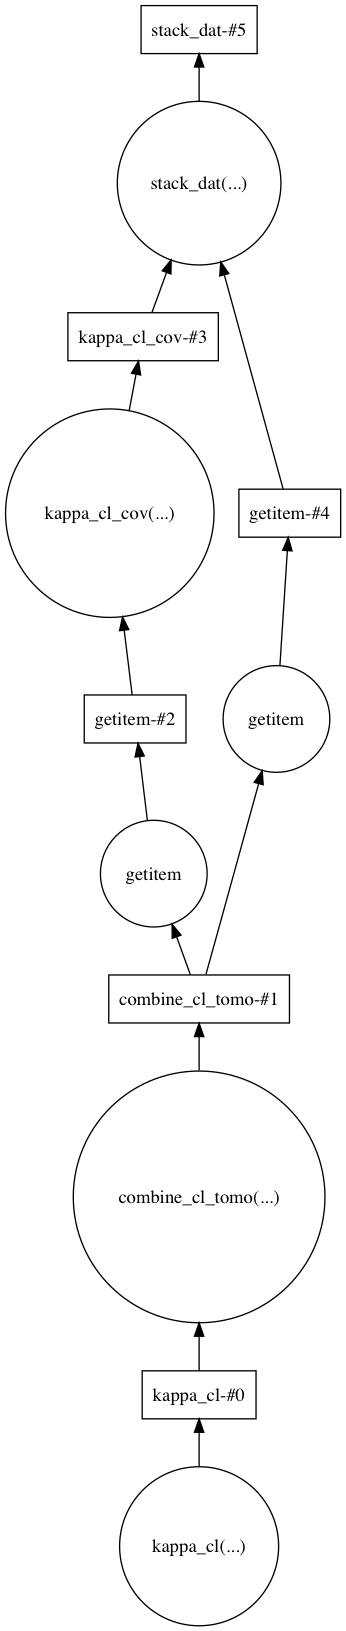

In [38]:
%time cl0G=kappa0.kappa_cl_tomo()
%time cl1G=kappa0.kappa_cl_tomo()#kappa1.kappa_cl_tomo()
cl0G['stack'].visualize()

In [63]:
%time cl0=cl0G['stack'].compute()
cov_inv=np.linalg.inv(cl0['cov'])

SN=np.sqrt(np.dot(cl0['cl'],np.dot(cov_inv,cl0['cl'])))
SN

CPU times: user 3.76 s, sys: 1.62 s, total: 5.38 s
Wall time: 3.27 s


303.11251773766293

In [58]:
cl0={}
cl1={}
%time cl0['cl']=cl0G['cl0'].compute()
%time cl0['cov']=kappa0.compute_cov_tomo(cl0G['cov0'])
%time cl1['cl']=cl1G['cl0'].compute()
%time cl1['cov']=kappa1.compute_cov_tomo(cl1G['cov0'])

CPU times: user 3.9 s, sys: 1.73 s, total: 5.64 s
Wall time: 3.43 s
CPU times: user 4.27 s, sys: 1.87 s, total: 6.14 s
Wall time: 3.86 s


In [59]:
cc=kappa0.cov_utils

In [60]:
cl0.keys()

dict_keys(['cov', 'cl'])

In [61]:
cl_t=cl0['cl']#[:,0,0]
cl_t2=cl1['cl'][:,0,0]
plot(lb,cl_t/cl_t2)

# xscale('log')
# ylim(8e-7,8.6e-7)
#yscale('log')

IndexError: too many indices for array

In [62]:
cov0=cl0['cov']#[(0,0,0,0)]
cov02=cl1['cov']#[(0,0,0,0)]
plot(lb,np.diag(cov02['G'])/np.diag(cov0['G']))
xscale('log')
#ylim(0.99,1.01)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


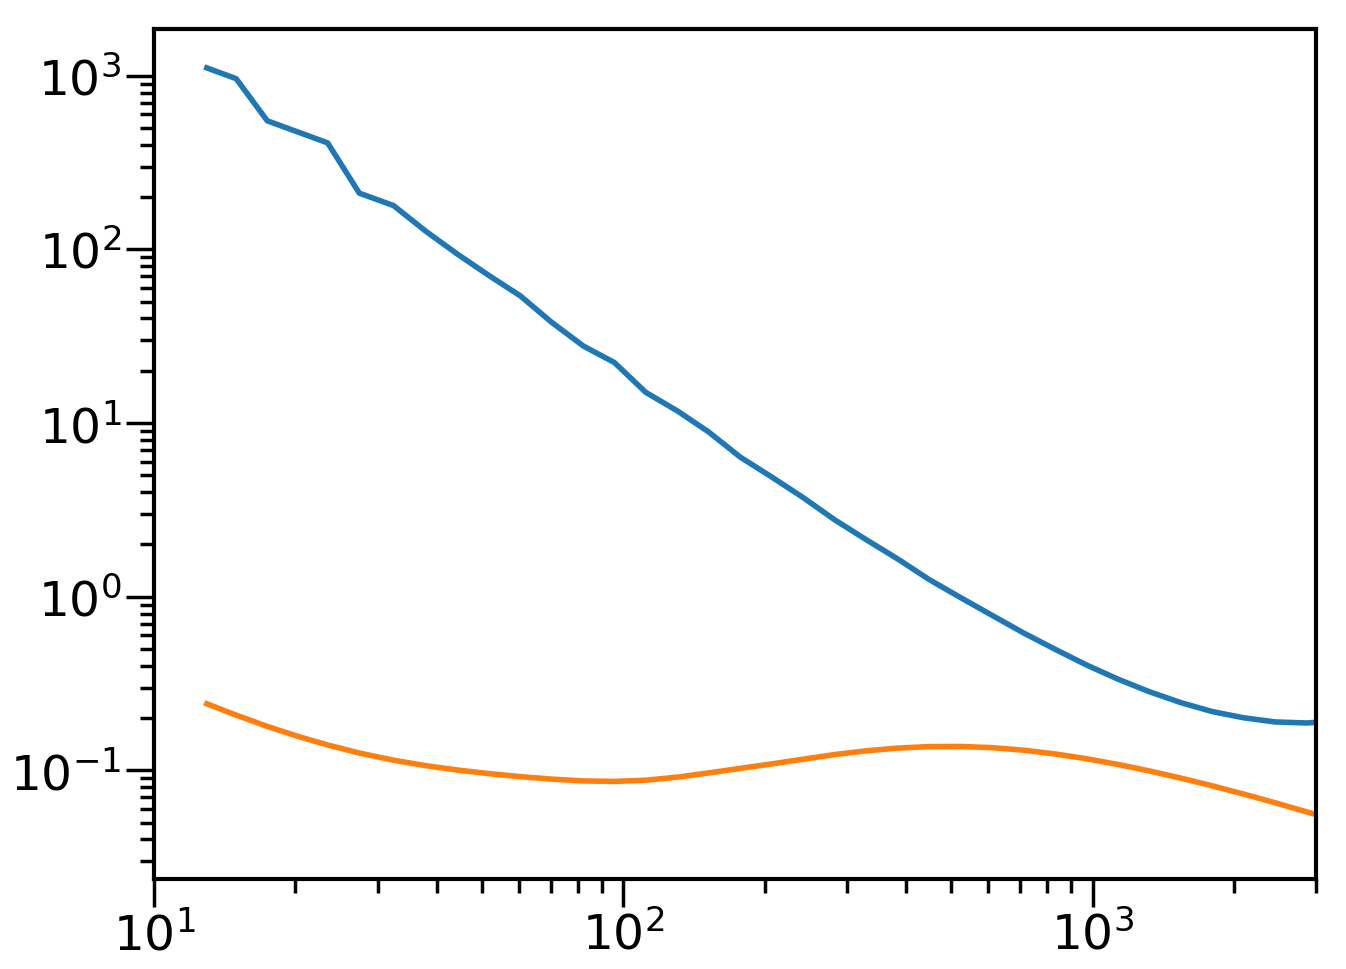

In [43]:
cov0=cl0['cov'][(0,0,0,0)]
f=1.e4
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
#plot(lb,np.diag(cov02['G'])/cl_t**2*f*0.95)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

(12, 4900)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


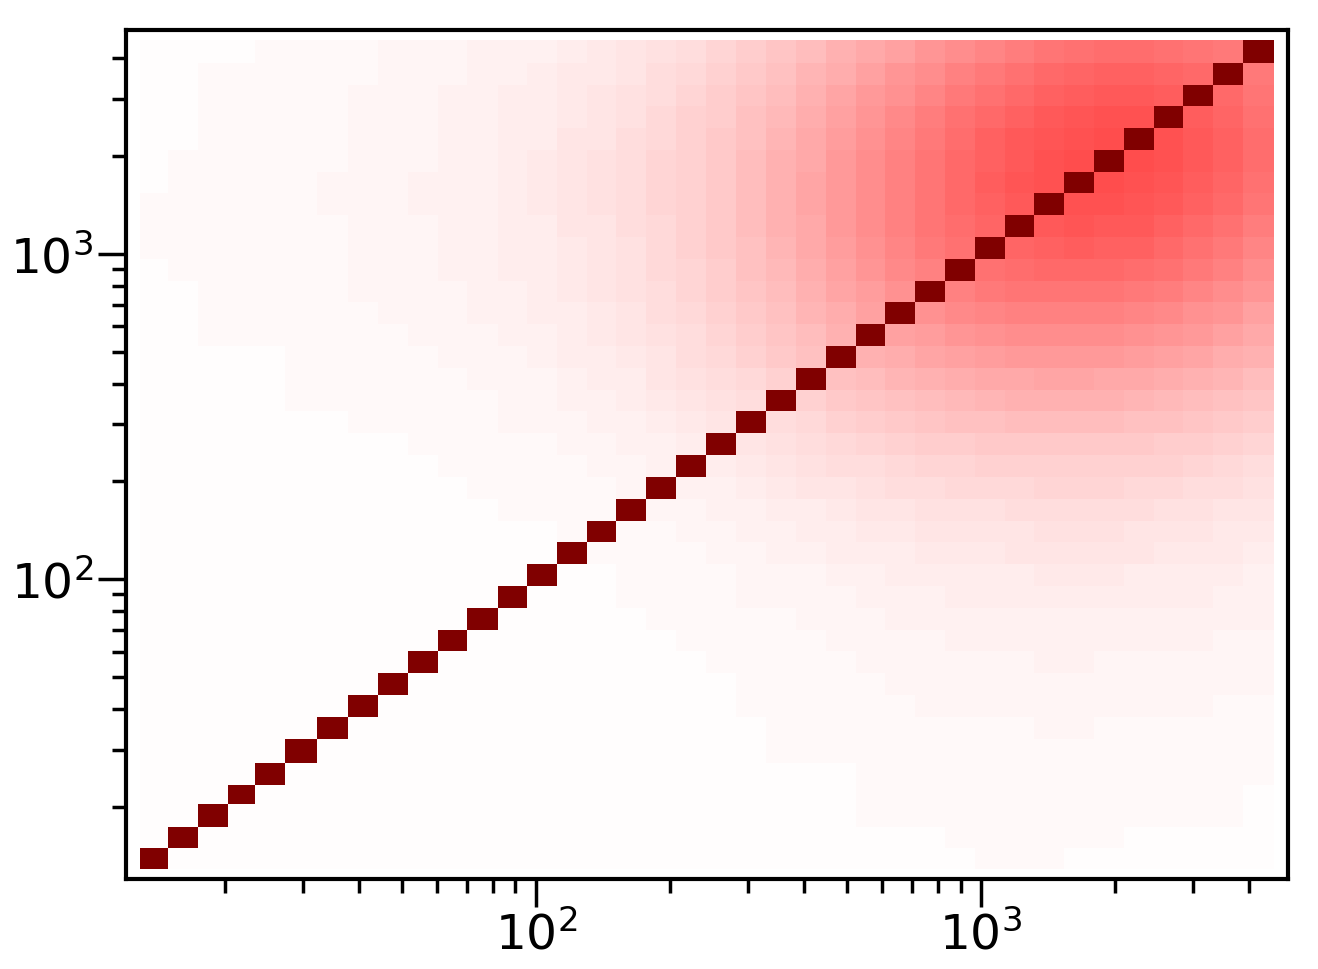

In [44]:
cov0=cl0['cov'][(0,0,0,0)]
corr2=kappa0.cov_utils.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(lmin_clB,lmax_clB)
ylim(lmin_clB,lmax_clB)

In [15]:
np.sum(ns)

inf

In [71]:
import lensing_utils
reload(lensing_utils)
import kappa_cl
reload(kappa_cl)
from kappa_cl import *

In [72]:
do_xi=False
bin_xi=True
bin_cl=True
th_bins=np.logspace(-1,1,20)

In [126]:
zmin=0.3
zmax=2
z=np.linspace(0,5,200)
pzs=lsst_zsource(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

nbins=5
zs_bins=np.linspace(zmin,zmax,nbins+1)
# zs_bins=np.linspace(.4,zmax,nbins+1)
nbins=15
# zl_bins=[0.2]#
zl_bins=np.linspace(zmin,zmax-0.2,nbins+1)

ns0=26
ns=ns0*pzs*np.gradient(z) #+np.inf

SSV_cov=True
tidal_SSV=True

In [154]:
kappaS = Kappa(zs=z,pzs=pzs,l=l,z_bins=zs_bins,lens_weight=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,ns=ns,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

kappaL = Kappa(zs=z,pzs=pzs,l=l,z_bins=zl_bins,lens_weight=True,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,ns=ns,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [155]:
np.diag(kappaL.SN[0]),np.diag(kappaS.SN[0])

(array([  4.03946223e-10,   4.48871660e-10,   5.04958826e-10,
          5.74111632e-10,   6.59085029e-10,   7.63710366e-10,
          8.93311911e-10,   1.05540807e-09,   1.26090040e-09,
          1.52616850e-09,   1.87697254e-09,   2.35627365e-09,
          3.04146566e-09,   4.08751790e-09,   5.85656068e-09,
          9.43600403e-09]),
 array([  1.34016380e-09,   1.31424667e-09,   1.79413654e-09,
          2.37486680e-09,   3.90862616e-09]))

In [129]:
kappaL.zs_bins[0]['ns']

20.876661010739124

In [130]:
kappaL.zs_bins[0]['ns']

20.876661010739124

In [131]:
zbt=kappaL.zs_bins[0]
dz=np.gradient(z)
np.sum(pzs*zbt['W'])/np.sum(zbt['pz']),np.sum(ns)/np.sum(pzs*dz)*np.sum(pzs*dz)

(1.0, 20.876661010739124)

In [158]:
%time fishS=fisher_calc(kappa_class=kappaS)
%time fishL=fisher_calc(kappa_class=kappaL)
cosmo_fid['As']/fishL['error'],cosmo_fid['As']/fishS['error']

[[  3.61857164e+22]]
CPU times: user 17min 57s, sys: 8min 46s, total: 26min 44s
Wall time: 10min 5s
[[  4.46745601e+22]]
CPU times: user 20min 40s, sys: 10min 5s, total: 30min 46s
Wall time: 11min 34s


(array([ 448.0907754]), array([ 403.27792387]))

In [132]:
from dask.distributed import Client
client = Client(processes=False)

In [156]:
%time clSG=kappaS.kappa_cl_tomo()
%time clLG=kappaL.kappa_cl_tomo()#kappa_cl_tomo()
# %time clS=clSG['stack'].compute()
# %time clL=clLG['stack'].compute()
# covS_inv=np.linalg.inv(clS['cov'])
# print (np.sqrt(np.dot(clS['cl'],np.dot(covS_inv,clS['cl']))))
# covL_inv=np.linalg.inv(clL['cov'])
# print (np.sqrt(np.dot(clL['cl'],np.dot(covL_inv,clL['cl']))))

CPU times: user 84.2 ms, sys: 24.7 ms, total: 109 ms
Wall time: 106 ms
CPU times: user 274 ms, sys: 66.9 ms, total: 341 ms
Wall time: 174 ms


In [157]:
%time clS['cl']=clSG['cl0'].compute()
# clL['cl']=clLG['cl0'].compute()
# clS['cov']=clSG['cov0'].compute()
# clL['cov']=clLG['cov0'].compute()



CPU times: user 51.1 s, sys: 1.66 s, total: 52.8 s
Wall time: 52 s


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


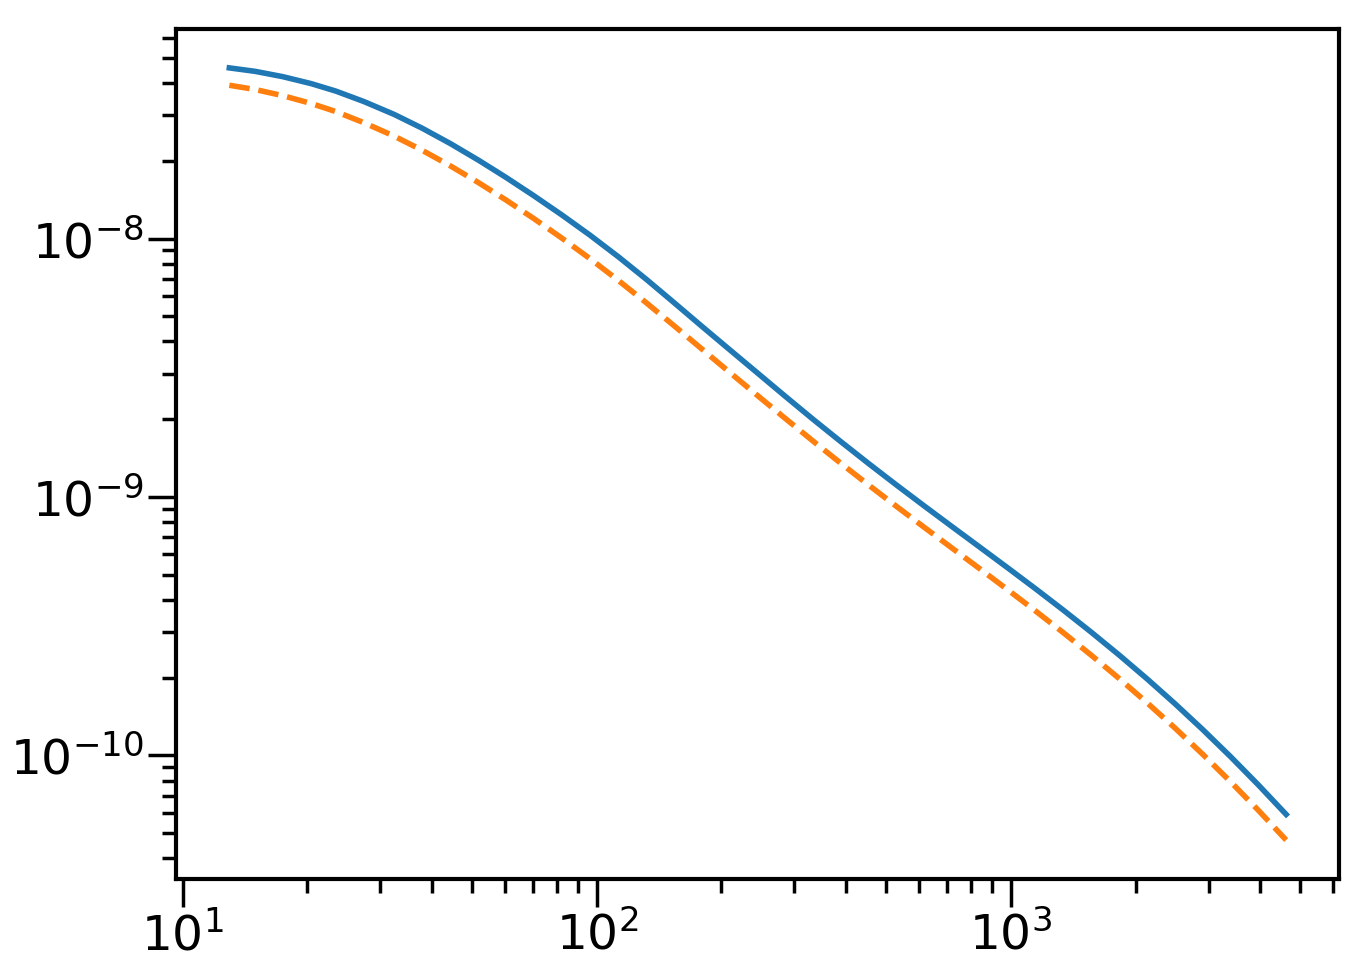

In [135]:
plot(lb,clS['cl'][:,2,2])
plot(lb,clL['cl'][:,0,0],'--')
xscale('log')
yscale('log')

ValueError: x and y can be no greater than 2-D, but have shapes (39,) and (39, 3, 3)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


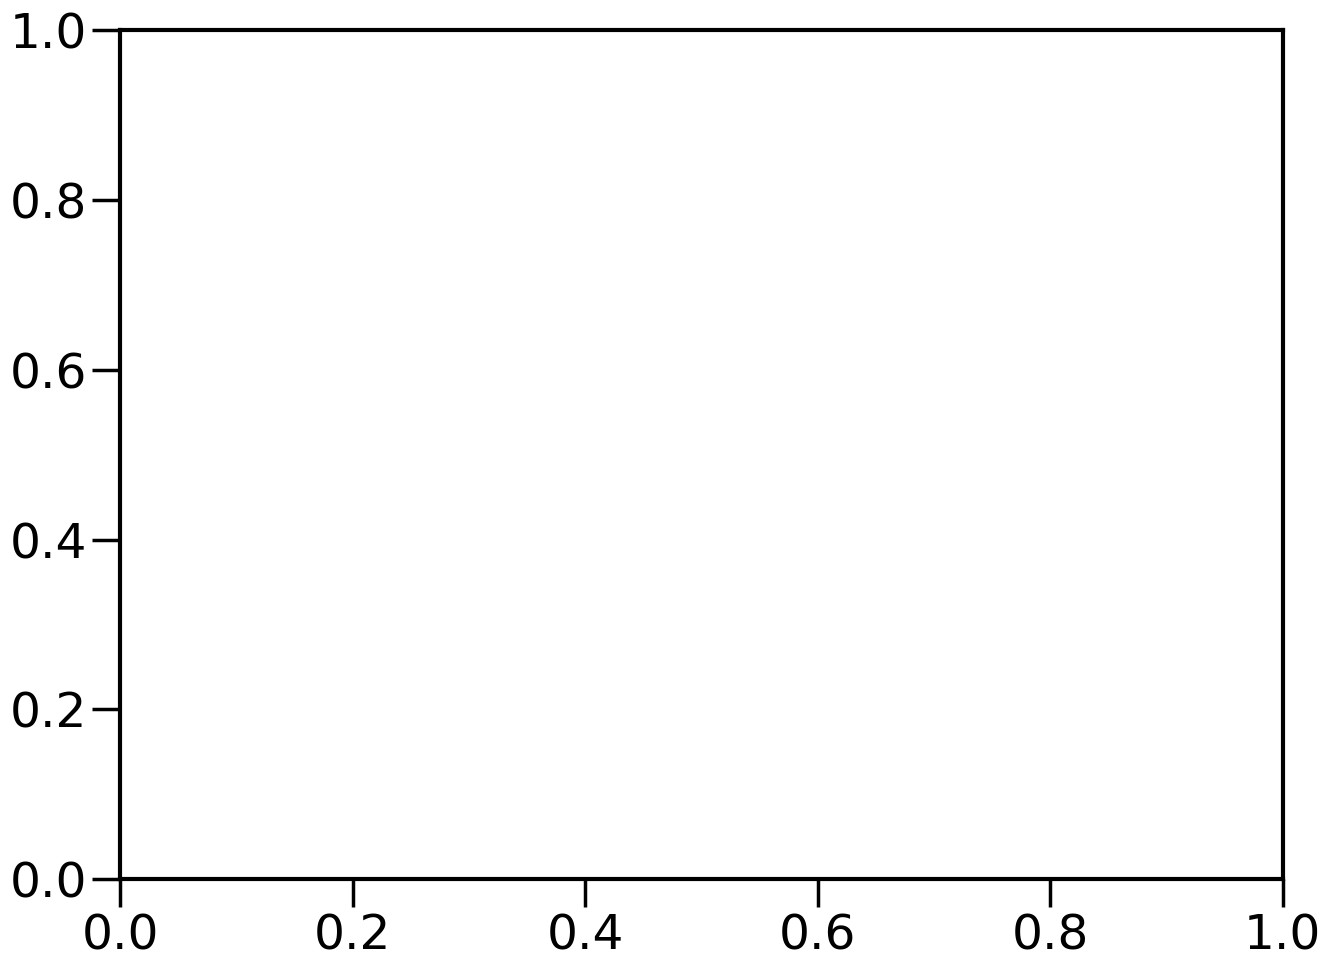

In [121]:
plot(lb,clS['cl'])
plot(lb,clL['cl'],'--')
xscale('log')
yscale('log')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


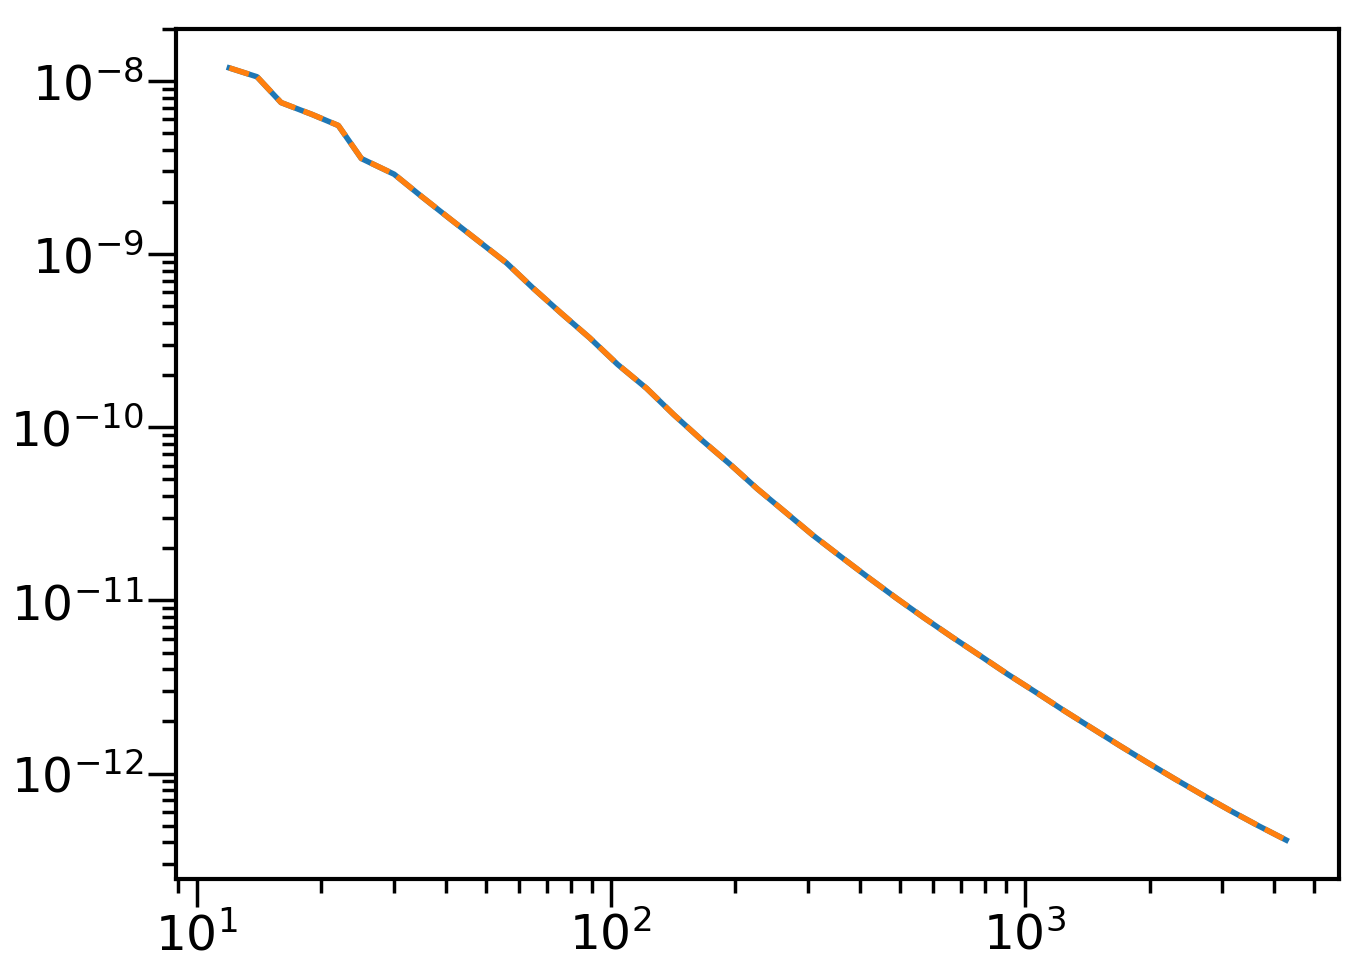

In [109]:
plot(l_bins[:-1],np.sqrt(np.diag(clS['cov'])))
plot(l_bins[:-1],np.sqrt(np.diag(clL['cov'])),'--')
xscale('log')
yscale('log')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


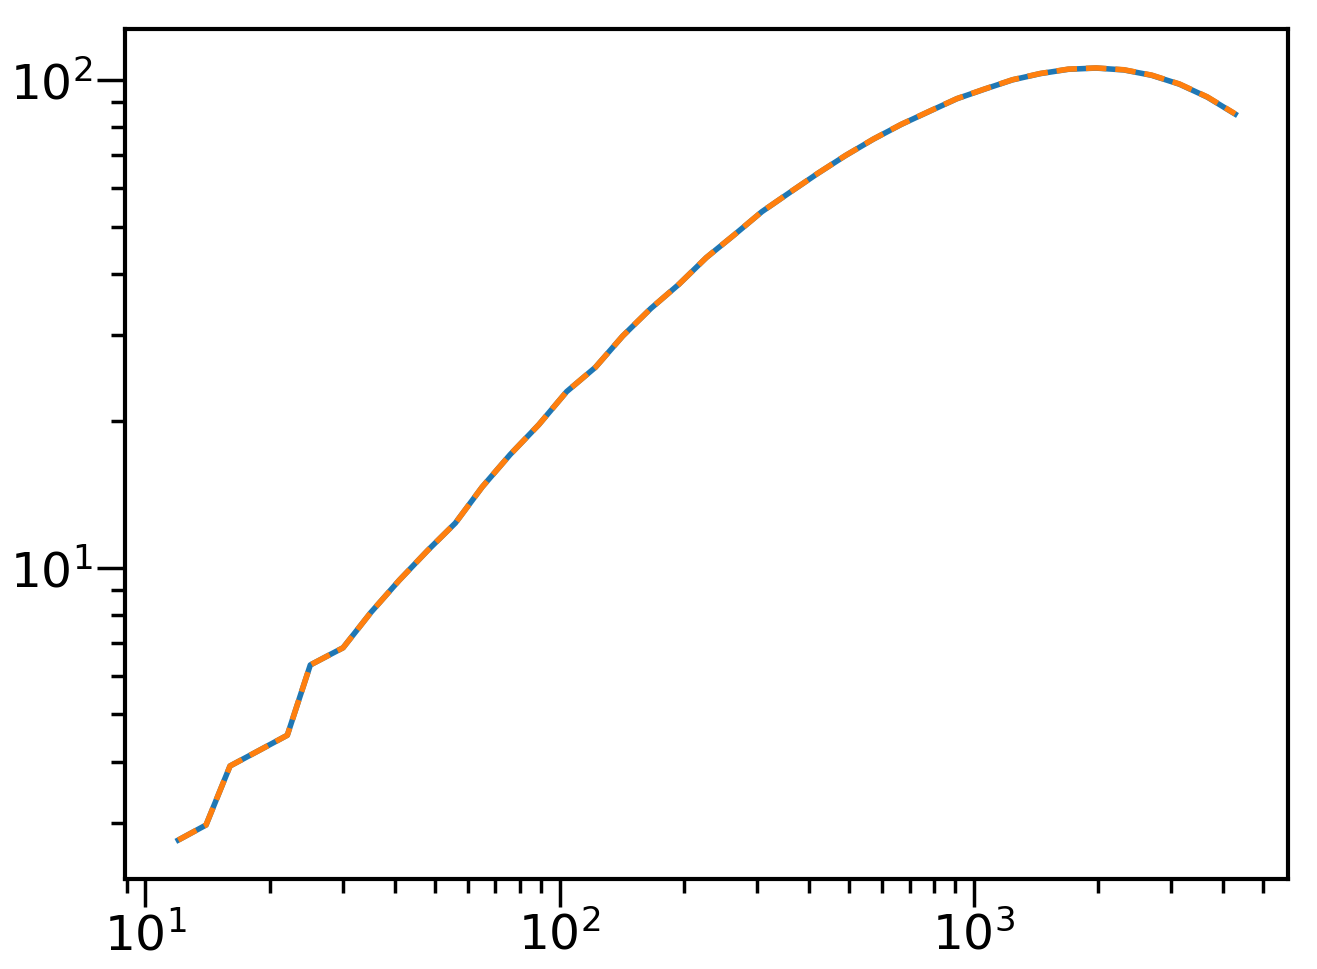

In [110]:
plot(l_bins[:-1],clS['cl']/np.sqrt(np.diag(clS['cov'])))
plot(l_bins[:-1],clL['cl']/np.sqrt(np.diag(clL['cov'])),'--')
xscale('log')
yscale('log')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


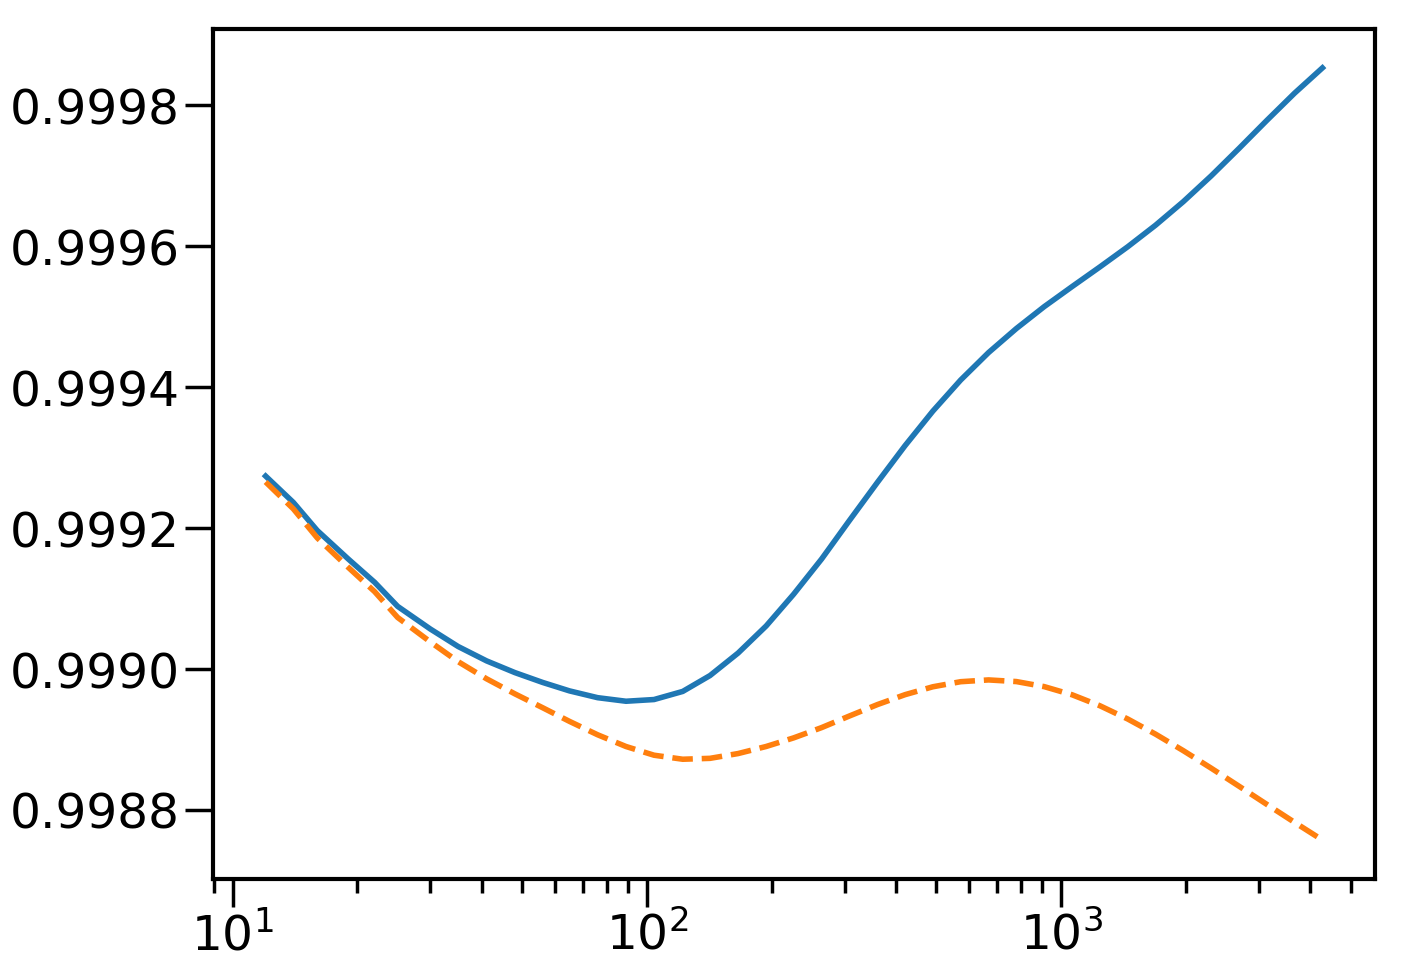

In [111]:
plot(l_bins[:-1],np.sqrt(np.diag(clS['cov']))/np.sqrt(np.diag(clL['cov'])))
plot(l_bins[:-1],clS['cl']/clL['cl'],'--')
xscale('log')
# yscale('log')

In [208]:
kappaL.SN

array([[[  4.97975207e-10]]])

In [209]:
np.diag(kappaL.SN[0]),np.diag(kappaS.SN[0])

(array([  4.97975207e-10]), array([  4.54303427e-10]))

In [184]:
zs_bins,zl_bins

(array([ 0.3,  2. ]), [0.29])

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


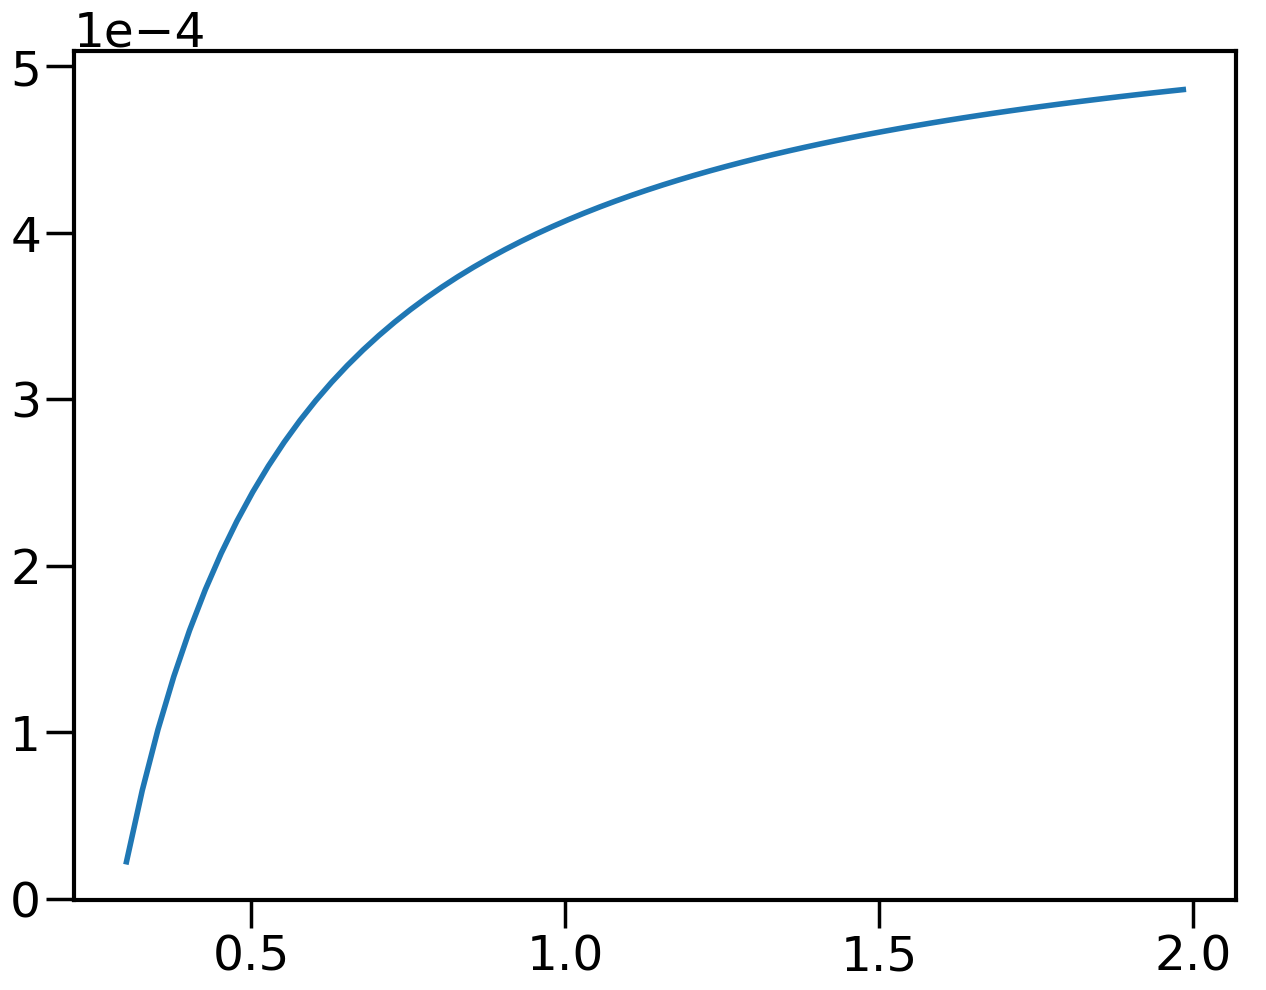

In [194]:
plot(z,kappaL.zs_bins[0]['W'])

In [ ]:
xiSG['stack'].visualize()

In [89]:
%time clSG=kappaS.kappa_cl_tomo()
clLG=kappaL.kappa_cl_tomo()#kappa_cl_tomo()
# %time clS=clSG['stack'].compute()
# %time clL=clLG['stack'].compute()

CPU times: user 172 ms, sys: 46.7 ms, total: 219 ms
Wall time: 194 ms


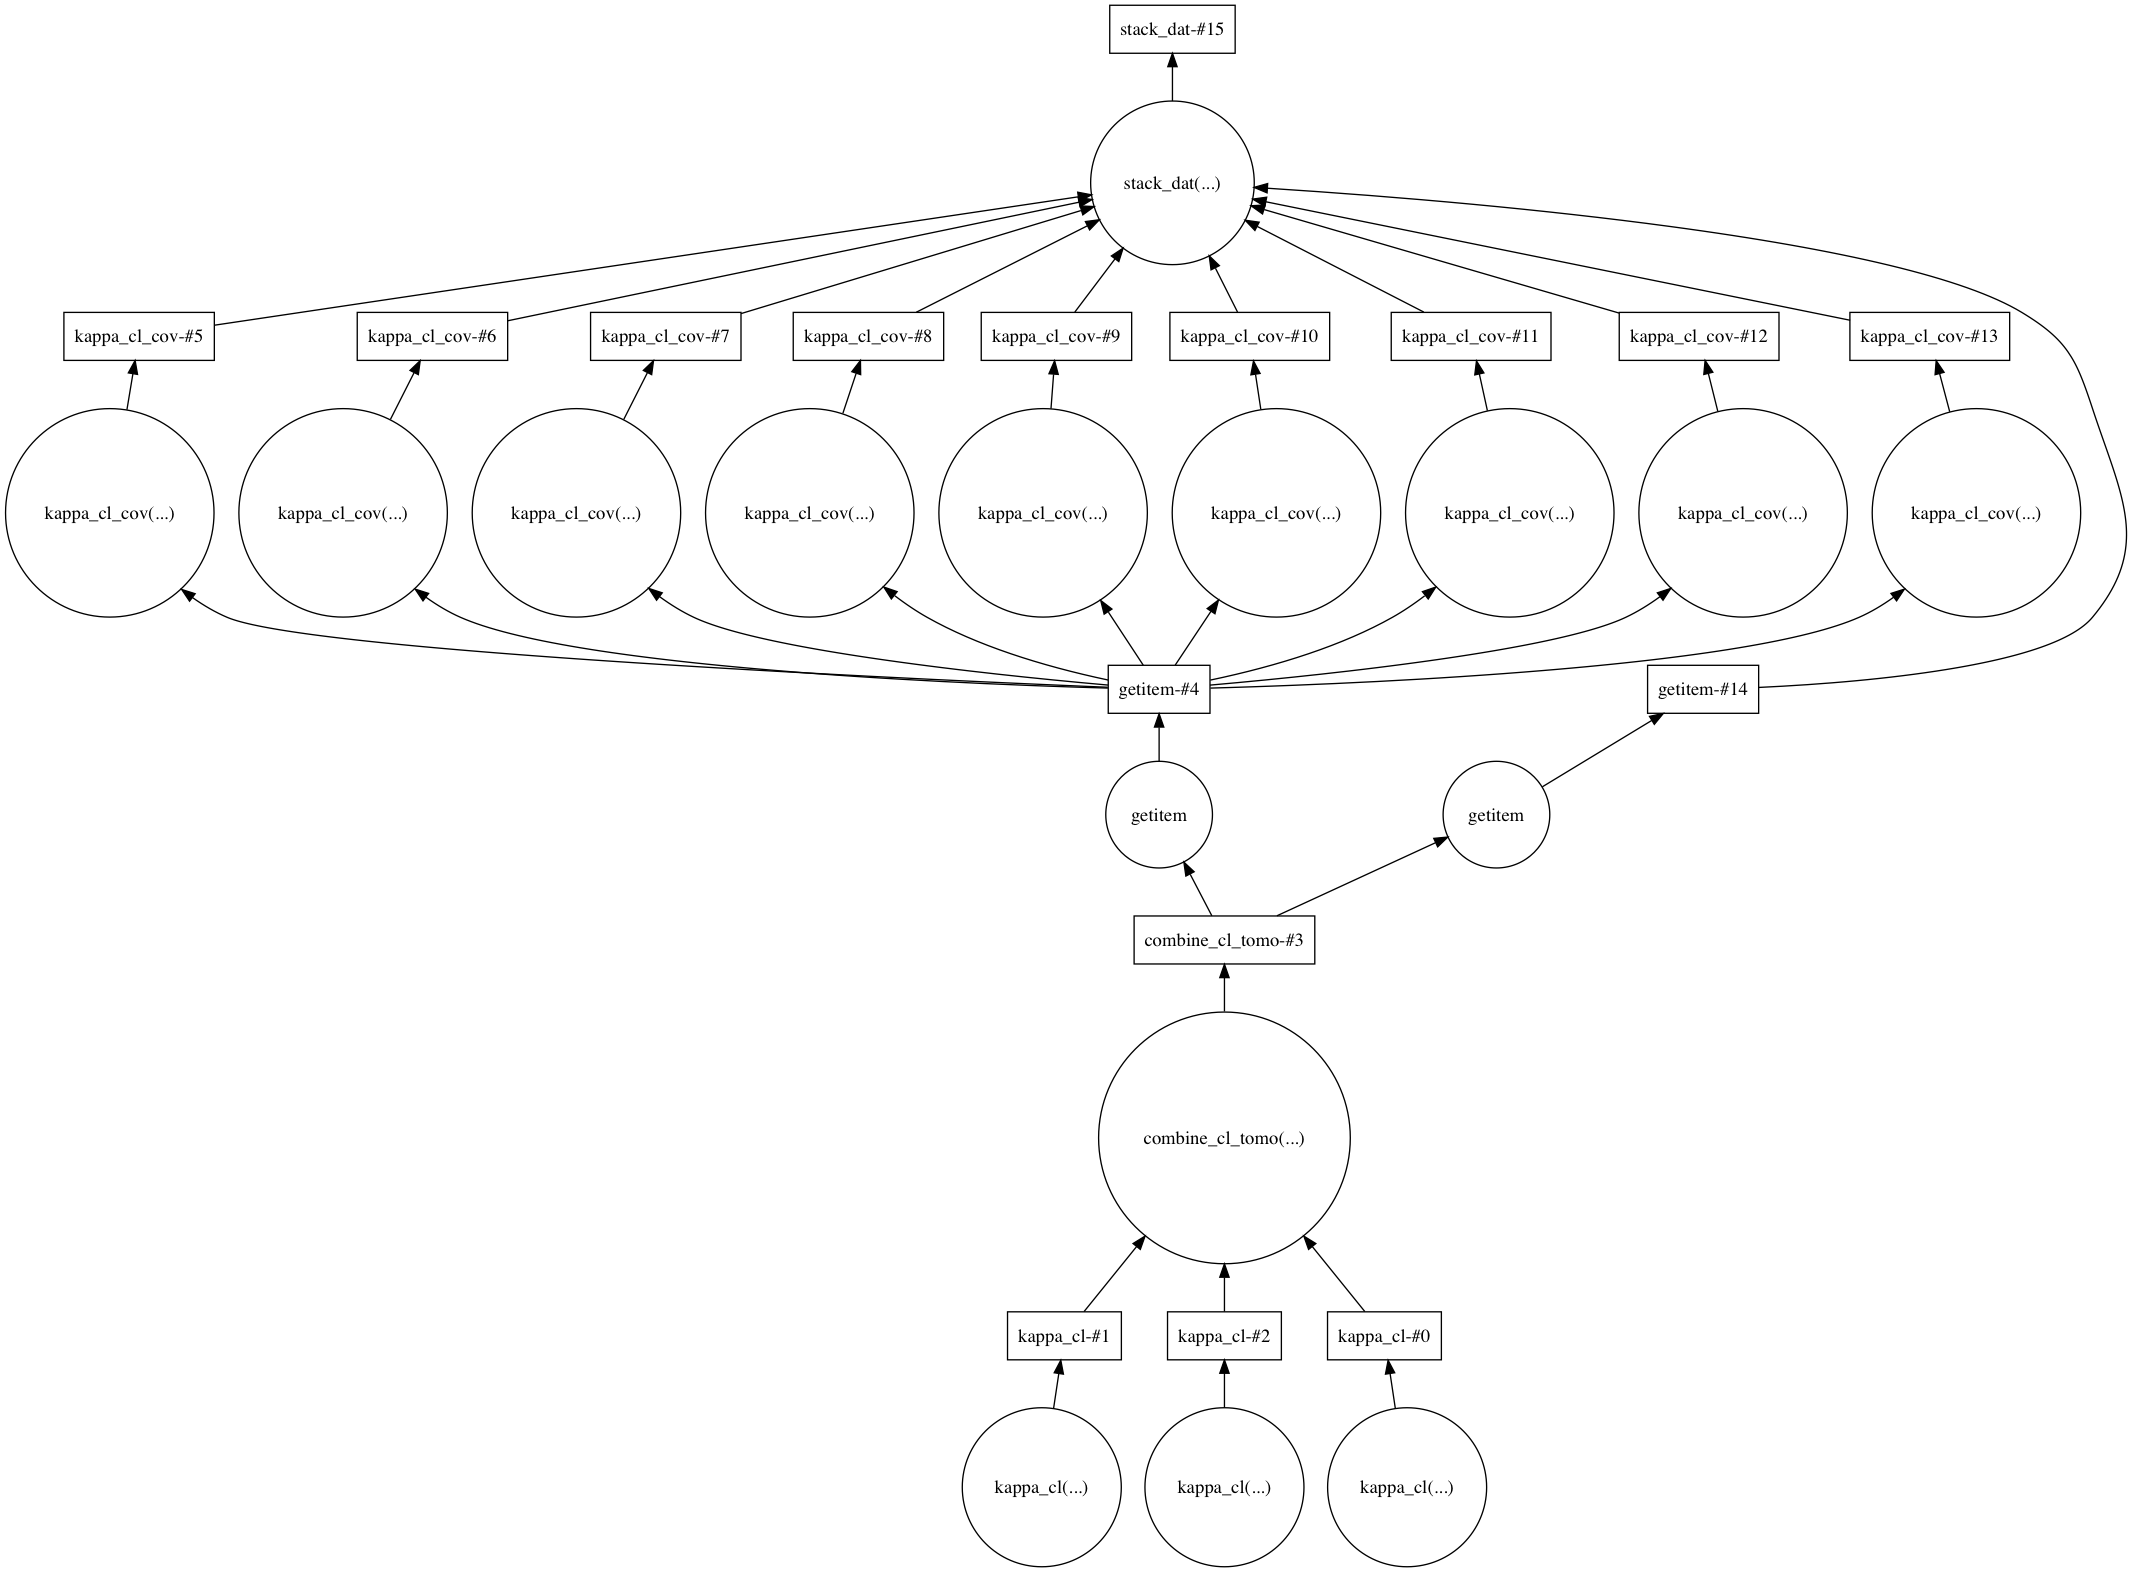

In [90]:
clSG['stack'].visualize()

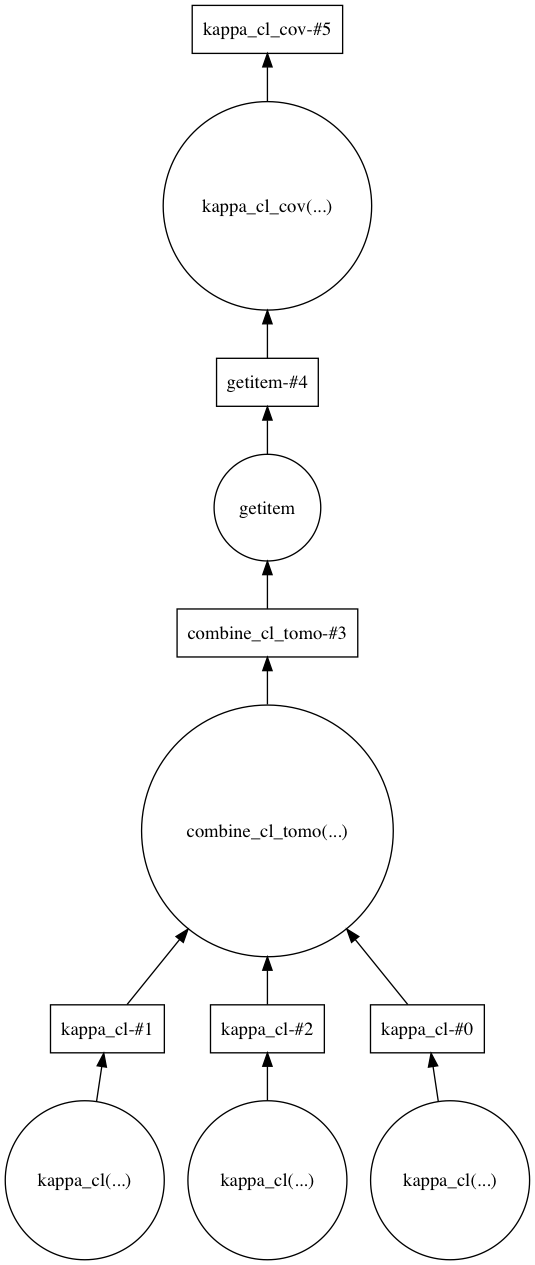

In [31]:
clSG['cov0'][(0,0,0,0)].visualize()

In [32]:
kappaS.SN

array([[[ 0.,  0.],
        [ 0.,  0.]]])

In [33]:
kappaL.SN

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

In [34]:
cl_b_stack=clS#kappaS.stack_dat(clS)
cl_Lb_stack=clL#kappaL.stack_dat(clL)
#clstack=kappaS.stack_dat(clS)

In [35]:
covS_inv=np.linalg.inv(cl_b_stack['cov'])
print (np.sqrt(np.dot(cl_b_stack['cl'],np.dot(covS_inv,cl_b_stack['cl']))))
covL_inv=np.linalg.inv(cl_Lb_stack['cov'])
print (np.sqrt(np.dot(cl_Lb_stack['cl'],np.dot(covL_inv,cl_Lb_stack['cl']))))

2677.12540971
3786.86599509


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


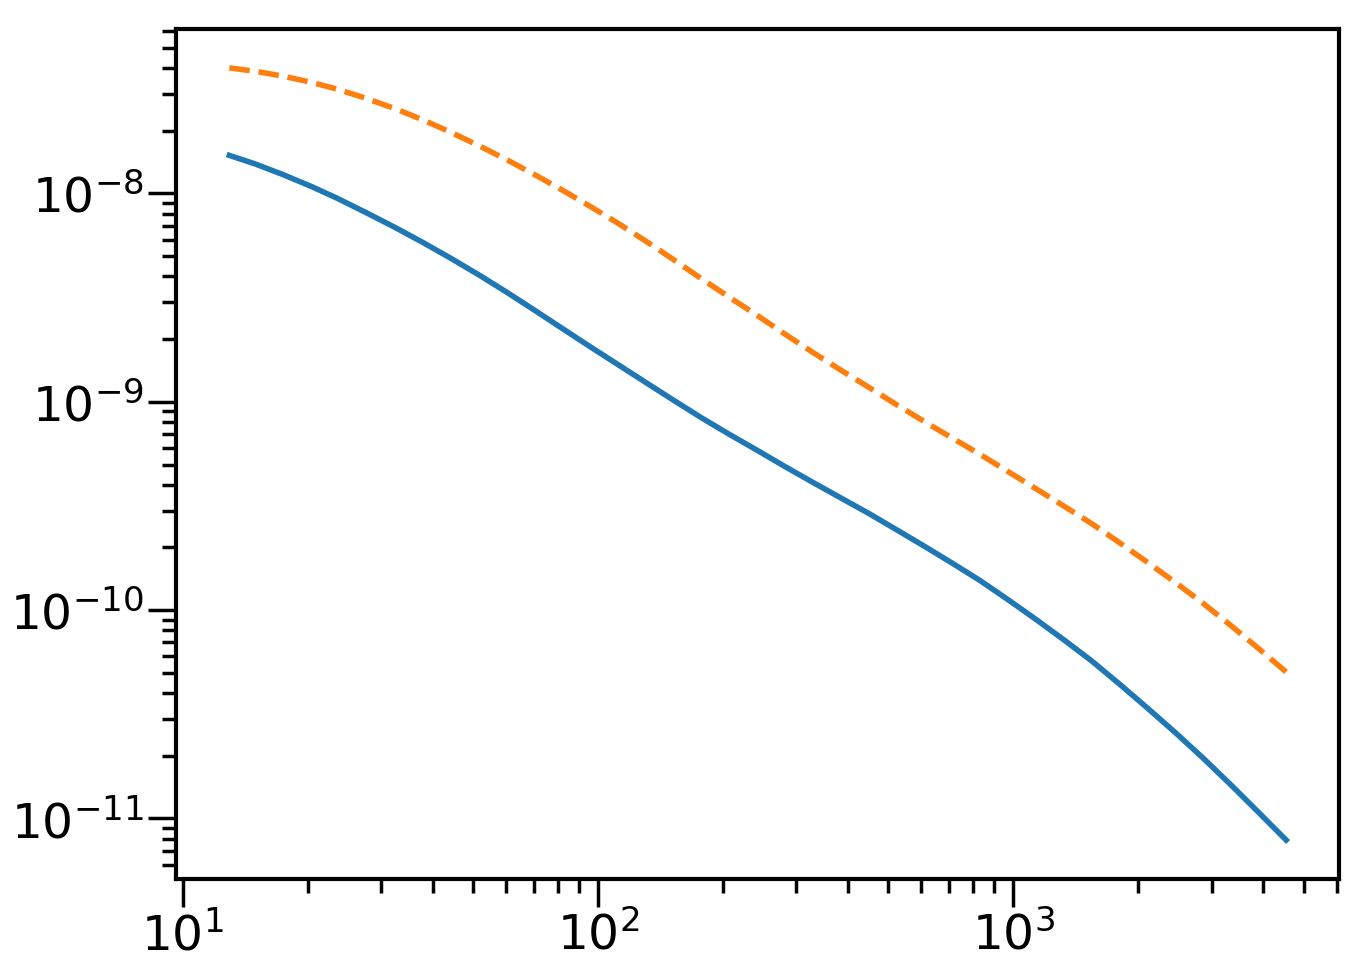

In [36]:
plot(clS['l'],clS['cl'][:,0,0])
#plot(clSb['l'],clSb['cl'][:,0,0])

plot(clL['l'],clL['cl'][:,0,0],ls='--')
# plot(clLb['l'],clLb['cl'][:,0,0])
xscale('log')
yscale('log')

In [21]:
corr=cc.corr_matrix(cl_b_stack['cov'])
corrL=cc.corr_matrix(cl_Lb_stack['cov'])

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


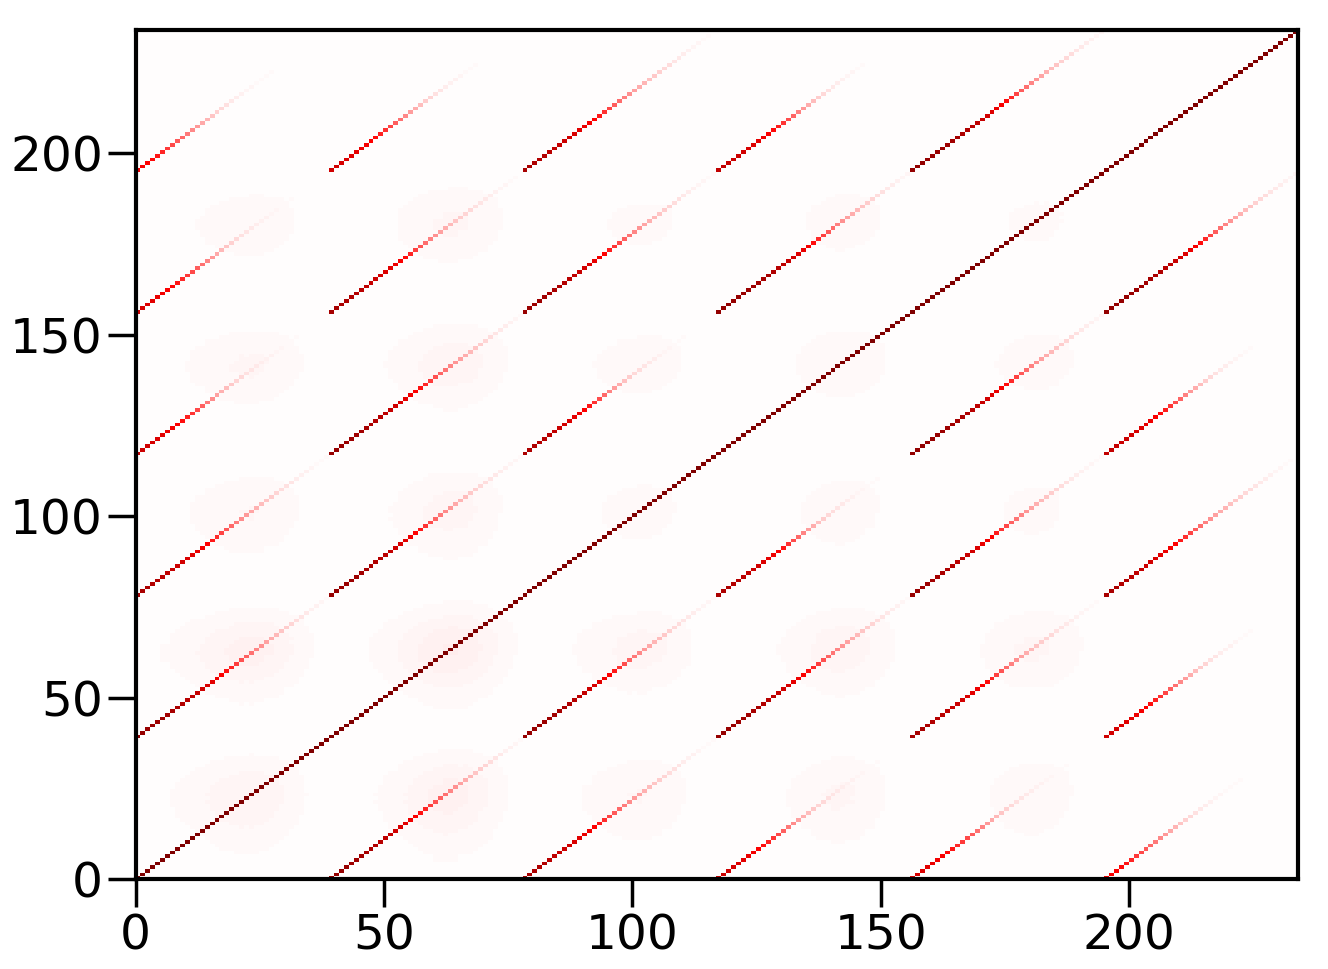

In [22]:
pcolor(corr,vmin=-1,vmax=1,cmap='seismic')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


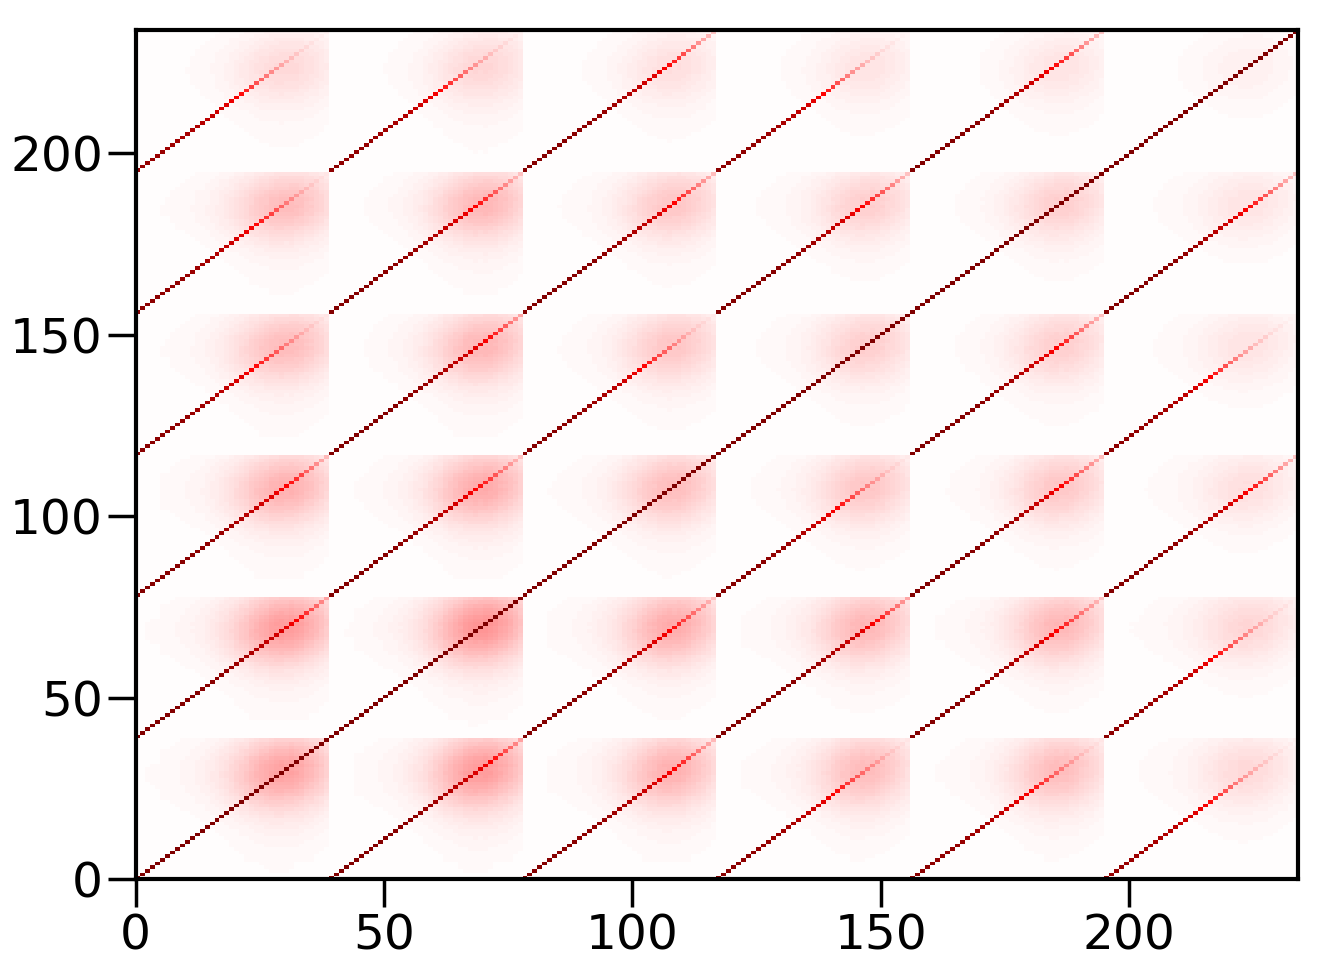

In [23]:
pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


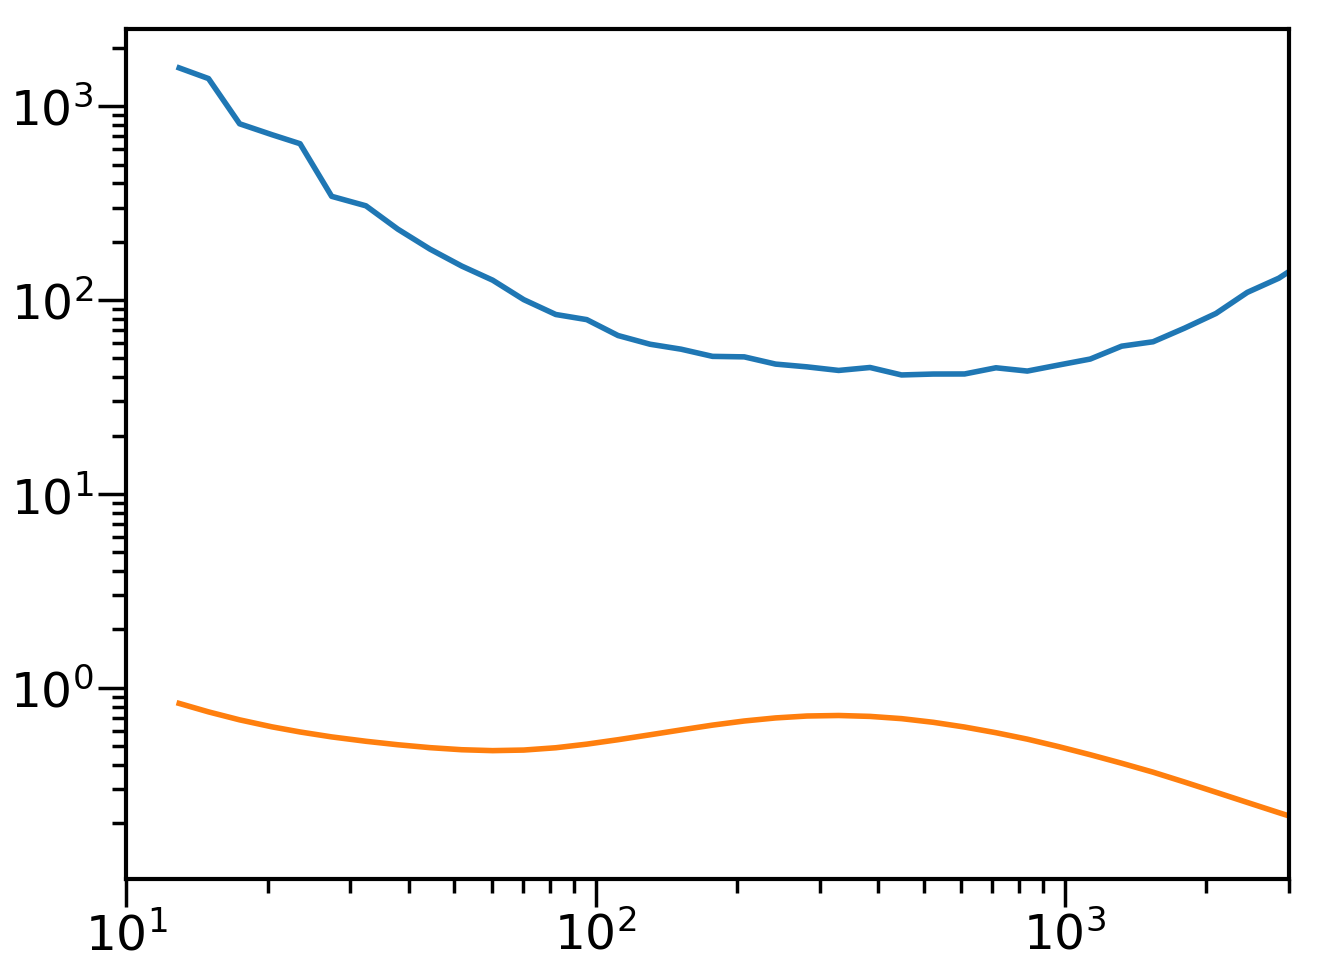

In [24]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clSb
cl01=clS
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


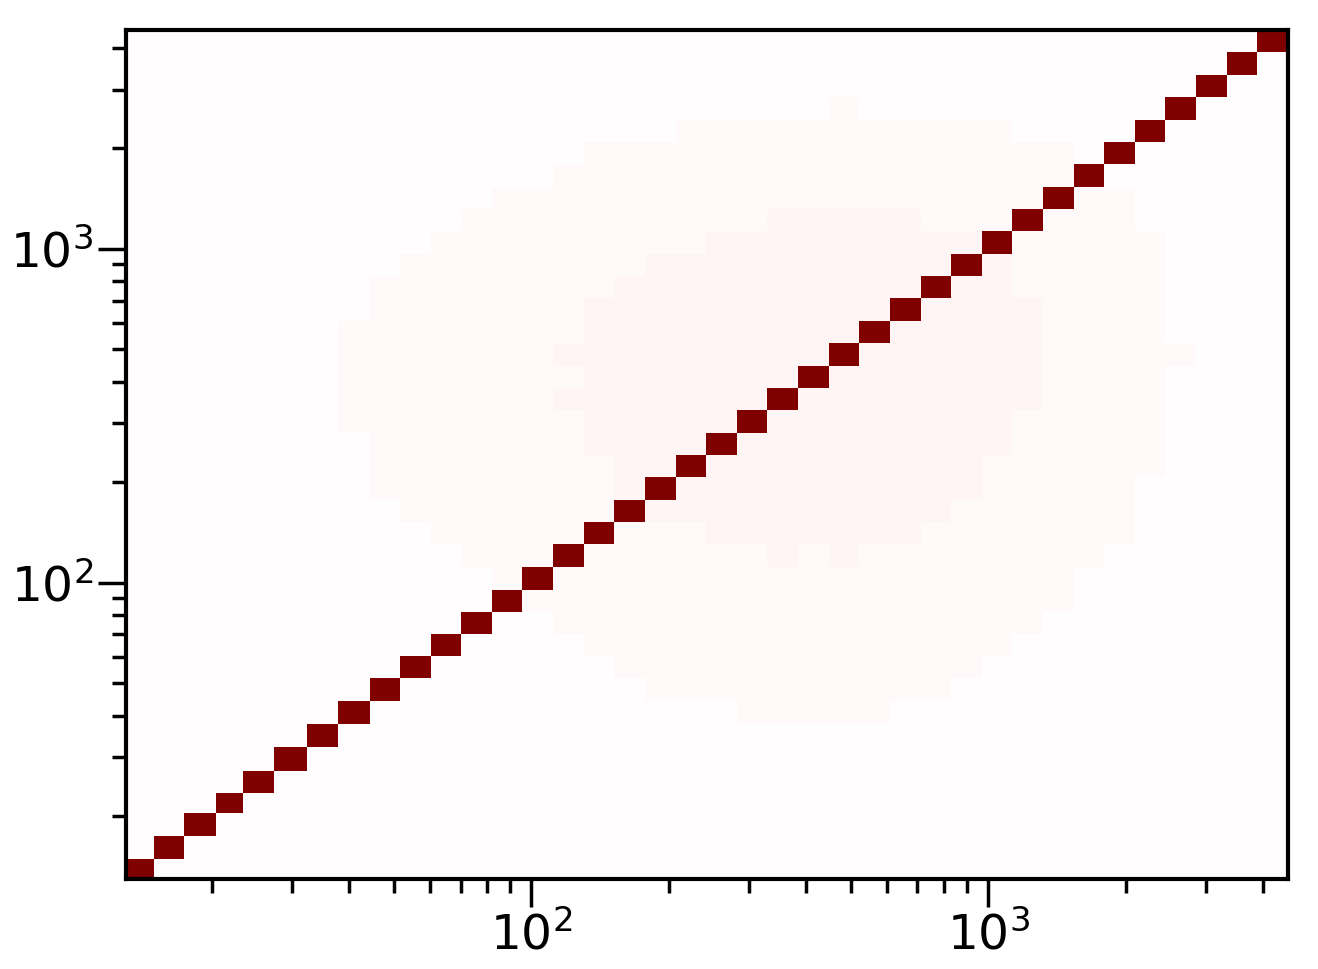

In [25]:
corr2=cc.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


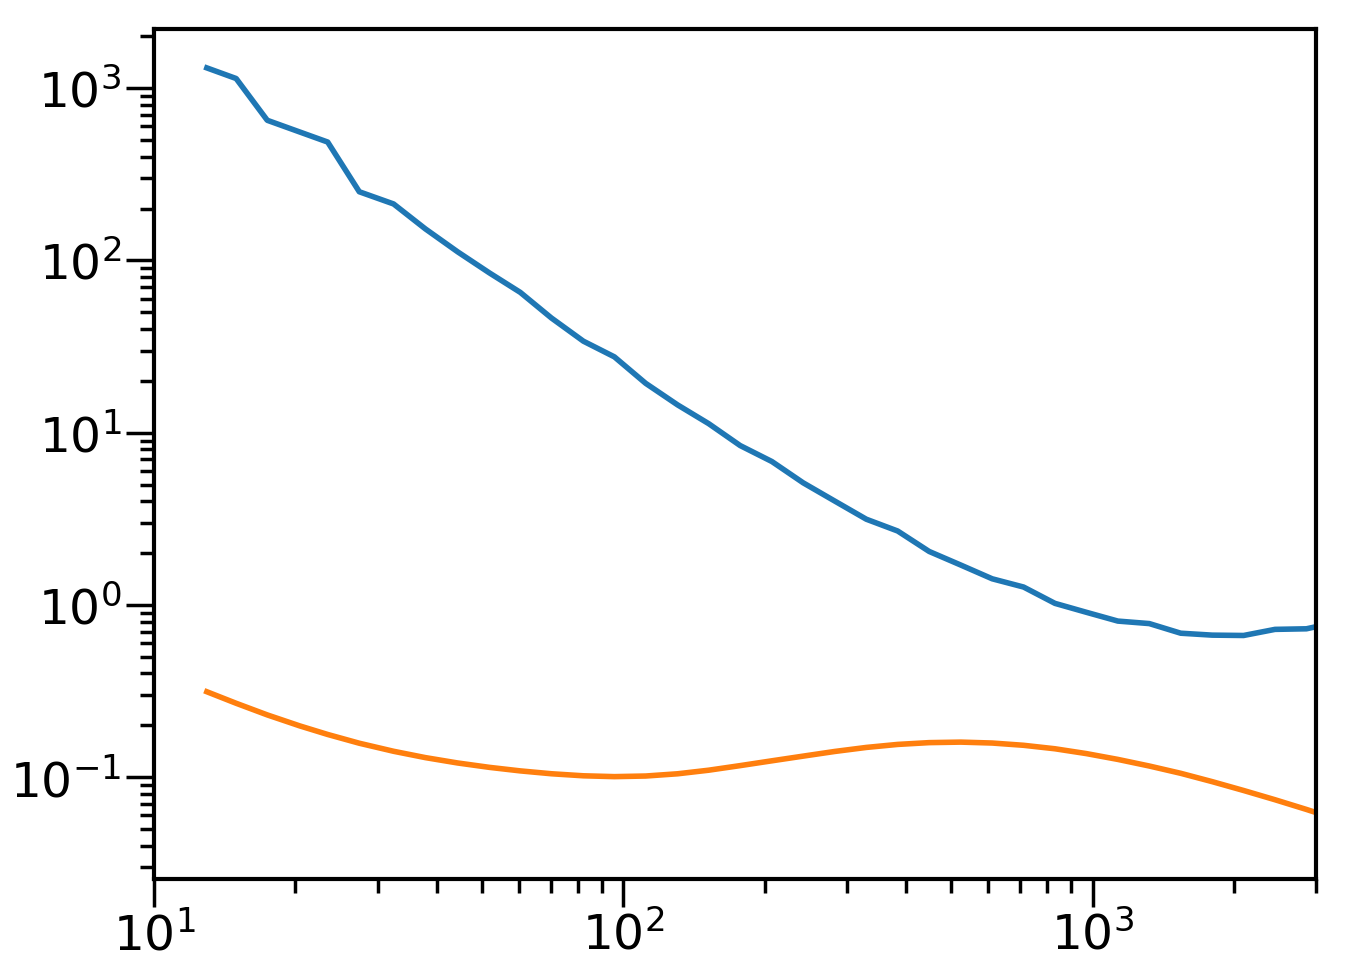

In [26]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clLb
cl01=clL
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)